# Setting Parameters

In [1]:
# Params
RANDOM_SEED = 45
BATCH_SIZE = 32

# Loading Packages

In [2]:
# Importing Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

# Loading Data

## EDA
This section contains the EDA we did to determine how to prep the data

### Figuring out which animal types have the most images
We want to chose 3 animals with the most images, to ensure there is enough training data for our model.

## Prep Data into DataFrame

In [3]:
# Put file paths in a DataFrame

# initialize dataframe
data = pd.DataFrame(columns=["path", "type"])

# Initialize directory and translate dict
home_dir = os.path.expanduser("~") + "/Desktop/APS360/Project"
dir = home_dir +  "/data/cartoonset10k"

for subdir in os.listdir(dir):
    data.loc[len(data)] = [dir + "/" + subdir, "dawg"]

data.head()

,path,type
0,/home/adam-taback/Desktop/APS360/Project/data/...,dawg
1,/home/adam-taback/Desktop/APS360/Project/data/...,dawg
2,/home/adam-taback/Desktop/APS360/Project/data/...,dawg
3,/home/adam-taback/Desktop/APS360/Project/data/...,dawg
4,/home/adam-taback/Desktop/APS360/Project/data/...,dawg


## Load into PyTorch

In [4]:
# import packages
from torch.utils.data import Dataset
from PIL import Image

### Define Dataset Class

In [5]:
# Define Dataset
class CartoonDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = np.asarray(X).ravel()
        self.y = np.asarray(y).ravel()
        self.transform = transform

        assert len(self.X) == len(self.y), f'X and y have different lengths -> {len(self.X)} != {len(self.y)} '

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        # print(f"Opening image: {img_path}")
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        label = self.y[idx]
        return (img, label)


    def show_img(self, idx):
        '''Plot image'''
        img, label = self.__getitem__(idx)
        if img is not None:
            img = img.numpy().transpose((1, 2, 0))
            plt.figure(figsize=(16, 8))
            plt.axis('off')
            plt.imshow(img)
            plt.title(label)
            plt.pause(0.001)

### Define Transforms

In [6]:
# Define Transforms
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

transform_test = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

### Generate Datasets and Plot examples

In [7]:
# Generate DataSets

cartoon_set = CartoonDataset(data["path"], data["type"],transform_test)

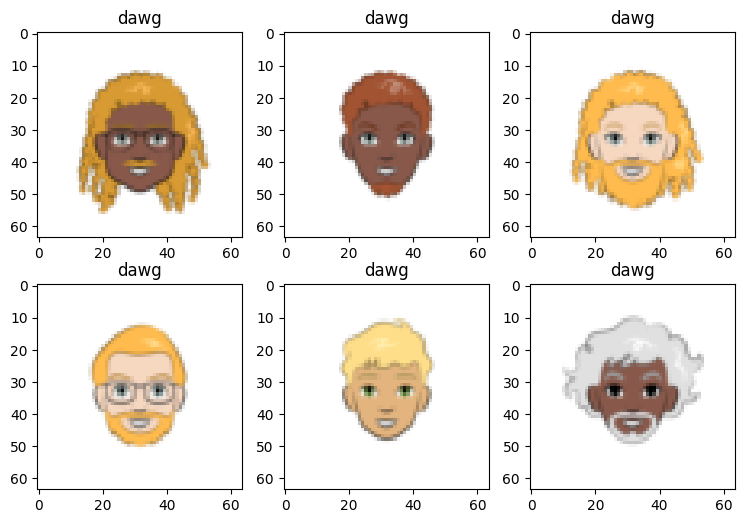

In [8]:
# Plot first 9 images

# define plot
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

# iterate
for i in range(2):
  for j in range(3):
    img, label = cartoon_set[i*3 + j]
    img = img.numpy().transpose((1, 2, 0))
    axes[i,j].imshow(img)
    axes[i,j].set_title(label)

### Prep Dataloaders

In [9]:
# make dataloader
from torch.utils.data import DataLoader

cartoon_loader = DataLoader(cartoon_set, batch_size=BATCH_SIZE, shuffle=False)

# Baseline Model

## Define Model Class

# Primary Model

In [10]:
# import packages
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as utils

In [11]:
# define variables
nchannels = 3
nepochs = 10
lr = 0.00008/5
batch_size = 32
ngpu = 1
size_noise = 100

sizeDF = 128
sizeGF = 128

# enable GPU for faster computation
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda')

## Generator

In [12]:
class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        
        self.dense = nn.Sequential(
            nn.Linear(input_dim, 128 * 8 * 8),  # Adjusted for 8x8 feature maps
            nn.ReLU(),
            nn.BatchNorm1d(128 * 8 * 8),
            nn.LeakyReLU(0.1)
        )
        
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.1),
            
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.LeakyReLU(0.1),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(64, momentum=0.9),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(64, 3, kernel_size=5, stride=1, padding=2),  # 64x64 -> 64x64 with 3 channels
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.dense(x)
        x = x.view(-1, 128, 8, 8)  # Reshape to (batch_size, 128, 8, 8)
        x = self.conv_layers(x)
        return x

## Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(nchannels, sizeDF, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.BatchNorm2d(sizeDF, momentum=0.9),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(sizeDF, sizeDF * 2, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(sizeDF * 2, momentum=0.9),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(sizeDF * 2, sizeDF * 4, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(sizeDF * 4, momentum=0.9),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(sizeDF * 4, sizeDF * 8, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.BatchNorm2d(sizeDF * 8, momentum=0.9),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(sizeDF * 8, 1, kernel_size=4, stride=1, padding=0)  # 4x4 -> 1x1
        )
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.dense = nn.Linear(1 * 1 * 1, 1)  # Adjusted for 4x4 input
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.dense(x)
        x = self.sigmoid(x)
        return x


## Training

Training Discriminator Model

- Forward pass with real images as input and obtain prediction (real/fake)
- Compute loss by comparing model output to array of 1's
- Forward pass with generated images and obtain prediction
- Compute loss by comparing model output to array of 0's
- Average losses
- Backward pass to update weights

Training Generator Model
- Compute loss by comparing model predictions to array of 1's
- Backward pass to update weights

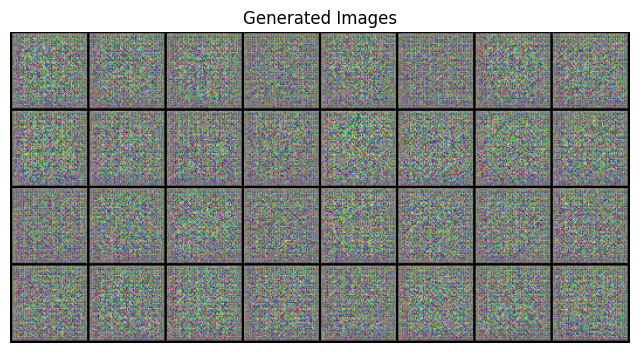

Starting Training Loop...
Epoch: 1, Generator Loss: 1.1569844626199703, Discriminator Loss: 0.5455958634234084


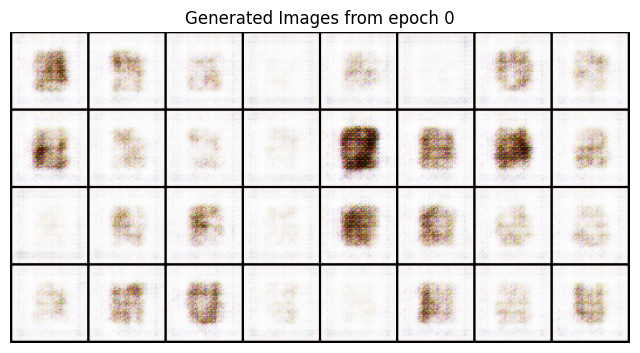

Epoch: 2, Generator Loss: 1.7578560167227308, Discriminator Loss: 0.4902812544339762
Epoch: 3, Generator Loss: 1.922196174962833, Discriminator Loss: 0.48225533819427124


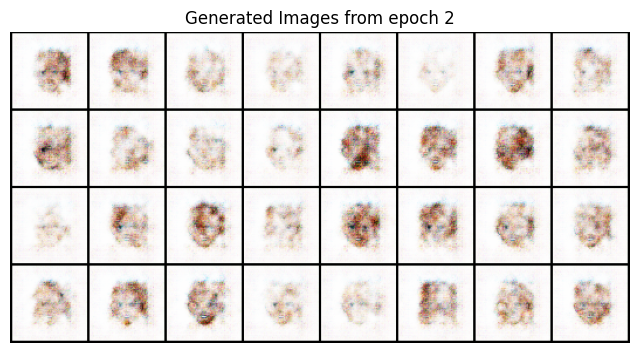

Epoch: 4, Generator Loss: 2.0413695958475717, Discriminator Loss: 0.48261617057430095
Epoch: 5, Generator Loss: 2.1153814922125576, Discriminator Loss: 0.47502578737827156


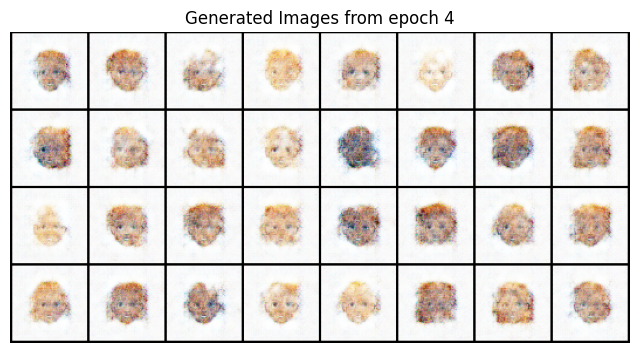

Epoch: 6, Generator Loss: 2.226180965527178, Discriminator Loss: 0.47646803277940414
Epoch: 7, Generator Loss: 2.273948745986524, Discriminator Loss: 0.47313888209125105


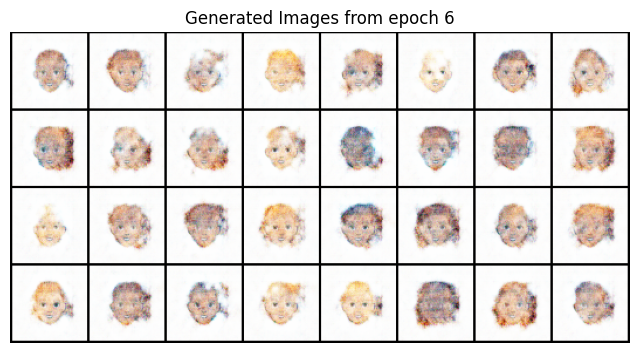

Epoch: 8, Generator Loss: 2.314655522568919, Discriminator Loss: 0.471034560650111
Epoch: 9, Generator Loss: 2.33460703368385, Discriminator Loss: 0.474334398540445


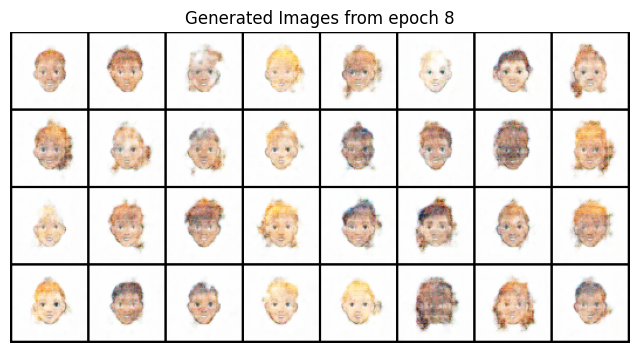

Epoch: 10, Generator Loss: 2.4222398440297037, Discriminator Loss: 0.4714243690521953


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Assume generator, discriminator, and gan (combined model) are defined
# Assume X_train is a DataLoader containing the training images

# define discriminator and generator
discriminator = Discriminator().to(device)
generator = Generator(size_noise).to(device)

# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr/4, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Labels for real and fake images
real_label = 0.0
fake_label = 1.0

# Loss function
criterion = nn.BCELoss()

# Function to generate noise
def generate_noise(batch_size, noise_dim):
    return torch.randn(batch_size, noise_dim, device=device)

# Move models to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Initialize fixed noise for generating images
fixed_noise = generate_noise(batch_size, size_noise)

# Generate and display initial images
with torch.no_grad():
    fake = generator(fixed_noise).detach().cpu()

# Display using matplotlib
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
plt.show()

G_losses = []
D_losses = []

print('Starting Training Loop...')
for epoch in range(nepochs):
    cum_d_loss = 0.
    cum_g_loss = 0.
    
    for i, data in enumerate(cartoon_loader, 0):
        # Get the next set of real images to be used in this iteration
        images, _ = data
        images = images.to(device)
        b_size = images.size(0)
        
        # Generate noise and fake images
        noise_data = generate_noise(b_size, size_noise)
        generated_images = generator(noise_data)
        
        # Train on soft labels (add noise to labels as well)
        noise_prop = 0.05  # Randomly flip 5% of labels
        
        # Prepare labels for real data
        true_labels = torch.zeros((b_size, 1), device=device) + torch.rand((b_size, 1), device=device) * 0.1
        true_labels = true_labels.to(device).clamp(0, 1)  # Ensure labels are within [0, 1]

        # Train discriminator on real data
        discriminator.zero_grad()
        output_real = discriminator(images).view(-1, 1)
        output_real_noisy = (output_real + 0.1 * torch.rand_like(output_real)).clamp(0, 1)  # Add noise and clamp to [0, 1]
        d_loss_real = criterion(output_real_noisy, true_labels)
        d_loss_real.backward()

        # Prepare labels for generated data
        gene_labels = torch.ones((b_size, 1), device=device) - torch.rand((b_size, 1), device=device) * 0.1
        gene_labels = gene_labels.to(device).clamp(0, 1)  # Ensure labels are within [0, 1]

        # Train discriminator on generated data
        output_fake = discriminator(generated_images.detach()).view(-1, 1)
        output_fake_noisy = (output_fake - 0.1 * torch.rand_like(output_fake)).clamp(0, 1)  # Add noise and clamp to [0, 1]
        d_loss_fake = criterion(output_fake_noisy, gene_labels)
        d_loss_fake.backward()
        d_optimizer.step()

        # Ensure losses are moved to CPU for item() method
        d_loss_real_item = d_loss_real.cpu().item()
        d_loss_fake_item = d_loss_fake.cpu().item()

        d_loss = 0.5 * (d_loss_real_item + d_loss_fake_item)
        cum_d_loss += d_loss

        # Train generator
        generator.zero_grad()
        noise_data = generate_noise(b_size, size_noise)
        gene_labels.fill_(real_label)  # All labels should be real for generator cost
        output_fake = discriminator(generator(noise_data)).view(-1, 1).clamp(0, 1)  # Clamp to [0, 1]
        g_loss = criterion(output_fake, true_labels)
        g_loss.backward()
        g_optimizer.step()

        cum_g_loss += g_loss.cpu().item()
        
    D_losses.append(cum_d_loss / len(cartoon_loader))
    G_losses.append(cum_g_loss / len(cartoon_loader))

    print('Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/len(cartoon_loader), cum_d_loss/len(cartoon_loader)))
    
    if epoch % (nepochs/5) == 0:
        # Generate and display images after each epoch
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Generated Images from epoch {}".format(epoch))
        plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
        plt.show()


Generator model saved to generator.pth
Losses saved to losses.npy


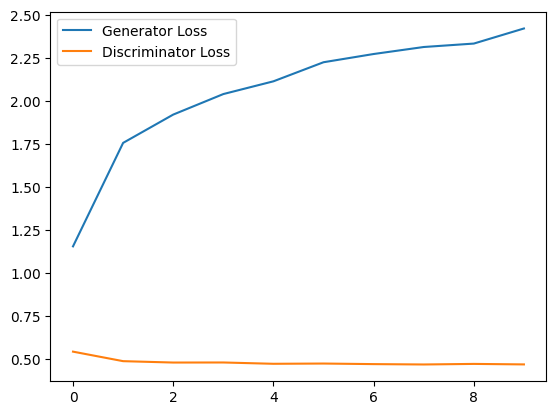

In [17]:
# Save the generator model
generator_path = "generator.pth"
torch.save(generator.state_dict(), generator_path)
print(f"Generator model saved to {generator_path}")

# Save the loss values
losses = {'G_losses': G_losses, 'D_losses': D_losses}
losses_path = "losses.npy"
np.save(losses_path, losses)
print(f"Losses saved to {losses_path}")

# Plot the losses
plt.figure()
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.legend()
plt.show()

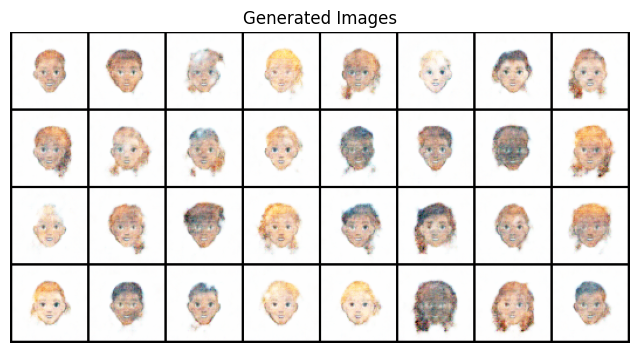

In [18]:
# plot the generated images
with torch.no_grad():
    fake = generator(fixed_noise).detach().cpu()
    
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1, 2, 0)))
plt.show()